# Initial model for individual fitting (the first stage)

In [9]:
from scipy.integrate import solve_ivp   
from scipy.optimize import curve_fit, least_squares
from datetime import datetime
import warnings
import pandas as pd
import numpy as np
import pandas as pd
import os


def seird_ode(t, y, alpha, beta, delta, lambda0, kappa,  Npop):
    S, E, I, Q, R, D = y

    # Differential equations:
    dS = -(beta * S * I + beta * 0.5 * S * Q)/ Npop
    dE = (beta * S * I + beta * 0.5 * S * Q)/ Npop - alpha * E
    dI = alpha * E - delta * I
    dQ = delta * I - (lambda0 + kappa) * Q
    dR = lambda0 * Q
    dD = kappa * Q

    return [dS, dE, dI, dQ, dR, dD]

def euler_seird_solver(alpha, beta,  delta, lambda0, kappa, Npop, y0, t_full):
    """
    使用欧拉法(dt=1)求解SEIRD模型
    """
    # 初始化
    n_steps = len(t_full)
    dt = 1  # 固定步长为1
    # 创建结果数组
    sol_y = np.zeros((len(y0), n_steps))
    sol_y[:, 0] = y0  # 初始条件
    # 欧拉法迭代
    for i in range(1, n_steps):
        t_prev = t_full[i-1]
        y_prev = sol_y[:, i-1]
        # 计算当前点的导数
        dydt = seird_ode(t_prev, y_prev, alpha, beta, delta, lambda0, kappa, Npop)
        # 欧拉公式: y_new = y_old + dt * dy/dt
        sol_y[:, i] = y_prev + dt * np.array(dydt)
    return sol_y

def fit_SEIRD(Q_data, R_data, D_data, Npop, E0, I0, time, guess, **kwargs):
    """
    Estimates the parameters for the SEIQRDP model using Lsqcurvefit logic.

    Args:
        Q_data (np.ndarray): Time-history of quarantined cases.
        R_data (np.ndarray): Time-history of recovered cases.
        D_data (np.ndarray): Time-history of dead cases.
        Npop (float): Total population.
        E0 (float): Initial exposed cases.
        I0 (float): Initial infectious cases.
        time (list or np.ndarray): Time series (datetime objects or days).
        guess (list or np.ndarray): Initial guess for parameters [alpha, beta, gamma, delta, lambda_params, kappa_params].

    Returns:
        tuple: Fitted parameters (alpha1, beta1, delta1, Lambda1, Kappa1).
        alpha: rate from exposed to infectious
        beta: infection rate
        delta: rate at which infectious people enter confirmed/quarantine
        lambda: cure rate
        kappa: moratalilty rate
    """
    tolX = kwargs.get('tolX', 1e-5)
    tolFun = kwargs.get('tolFun', 1e-5)
    dt = 1

    # Data preprocessing
    Q_data = np.maximum(Q_data, 0)
    R_data = np.maximum(R_data, 0)
    D_data = np.maximum(D_data, 0)

    has_R = not np.all(R_data == 0) and not np.any(np.isnan(R_data))

    t_target = np.array(time)
    t_full = np.arange(t_target[0], t_target[-1] + dt, dt)

    guess = list(guess) 
    initial_params = np.array(guess)

    def model_for_fitting(t_target, *para):
        alpha, beta, delta, lambda0, kappa = para[:5]
        #print(f"Testing parameters: alpha={alpha}, beta={beta}, delta={delta}, lambda0={lambda0}, kappa={kappa}")
        # Initial conditions
        S0 = Npop - Q_data[0] - D_data[0] - E0 - I0
        if has_R:
            S0 -= R_data[0]
        y0 = [S0, E0, I0, Q_data[0], R_data[0] if has_R else 0, D_data[0]]
        #solve ODE
        # sol = solve_ivp(
        #     fun=lambda t,y: seird_ode(
        #         t, y, alpha, beta, delta, lambda0, kappa, Npop
        #     ),
        #     t_span=(t_full[0], t_full[-1]),
        #     y0 = y0,
        #     t_eval = t_full,
        #     method = 'RK45'
        # )
        # Q_model = sol.y[3, :]
        # R_model = sol.y[4, :]
        # D_model = sol.y[5, :]
        ### use euler
        sol = euler_seird_solver(alpha, beta,  delta, lambda0, kappa, Npop, y0, t_full)
        Q_model = sol[3, :]
        R_model = sol[4, :]
        D_model = sol[5, :]

        Q_interp = np.interp(t_target, t_full, Q_model)
        R_interp = np.interp(t_target, t_full, R_model)
        D_interp = np.interp(t_target, t_full, D_model)
        
        if has_R:
            return np.concatenate((Q_interp, R_interp, D_interp))
        else:
            return np.concatenate((Q_interp, D_interp))
    
    # Set parameter bounds based on MATLAB logic
    ub = [1/2, 5.0, 2.0,  0.2, 0.05]
    lb = [1/10, 0.02, 0.1, 0.01, 0.0]

    if has_R:
        target_data = np.concatenate((Q_data, R_data, D_data))
    else:
        target_data = np.concatenate((Q_data, D_data))

    wQ = 1.0 / (np.max(Q_data) + 1e-6)
    wR = 1.0 / (np.max(R_data) + 1e-6) if has_R else 1.0
    wD = 1.0 / (np.max(D_data) + 1e-6)

    weights = np.concatenate((
        np.full_like(Q_data, wQ, dtype=float),
        np.full_like(R_data, wR, dtype=float) if has_R else [],
        np.full_like(D_data, wD, dtype=float)
    ))

    def residuals(p, t, data):
        pred = model_for_fitting(t, *p)
        return (pred - data) * weights
    
    result = least_squares(
        #lambda p, t, data: model_for_fitting(t, *p) - data,
        residuals,
        x0=initial_params,
        args=(t_target, target_data),
        bounds=(lb, ub),
        ftol=tolFun,
        xtol=tolX,
        verbose=1
    )
    coeffs = result.x
    final_cost = result.cost
    #print("Final cost:", final_cost)
    
    # Extract fitted parameters
    alpha1 = coeffs[0]
    beta1 = coeffs[1]
    delta1 = coeffs[2]
    Lambda1 = coeffs[3]
    Kappa1 = coeffs[4]

    return alpha1, beta1, delta1, Lambda1, Kappa1, final_cost

In [10]:
def fit_function(df, initial_conditions=None):
    if initial_conditions is None:
        E = np.arange(1000,10000,500)
        I = np.arange(1000,10000,500)
        min_cost = float('inf')
        best_E0 = None
        best_I0 = None
        for E0 in E:
            for I0 in I:
                try:
                    alpha1, beta1,  delta1, Lambda1, Kappa1, final_cost = fit_SEIRD(
                        Q_data=df['Active'].values,
                        R_data=df['Recovered'].values,
                        D_data=df['Deaths'].values,
                        Npop=df['Population'].values[0],
                        E0=E0,
                        I0=I0,
                        time=np.arange(len(df)),
                        guess=[0.2, 0.5,  0.1, 0.1, 0.001]
                    )
                    print("E0:", E0, "I0:", I0, "Final cost:", final_cost)
                    if final_cost < min_cost:
                        min_cost = final_cost
                        best_E0 = E0
                        best_I0 = I0
                except Exception as e:
                    print("E0:", E0, "I0:", I0, "Error")
                    continue
        print("最小final cost:", min_cost, "对应E0:", best_E0, "对应I0:", best_I0)
            # 使用最佳的E0和I0进行最终拟合
        E0 = best_E0
        I0 = best_I0
    else:
        E0, I0 = initial_conditions
    alpha1, beta1, delta1, Lambda1, Kappa1, final_cost = fit_SEIRD(
        Q_data=df['Active'].values,
        R_data=df['Recovered'].values,
        D_data=df['Deaths'].values,
        Npop=df['Population'].values[0],
        E0= E0,
        I0 = I0,
        time = np.arange(len(df)),
        guess=[0.2, 0.5,  0.1, 0.1, 0.001]
    )
    print("alpha1:", alpha1, "beta1:", beta1,  "delta1:", delta1, "Lambda1:", Lambda1, "Kappa1:", Kappa1)
    print("R0:", beta1 / delta1 + beta1 * 0.5 / (Lambda1 + Kappa1))
    print("Final cost:", final_cost)
    return (alpha1, beta1, delta1, Lambda1, Kappa1), E0, I0

# Plot results

In [12]:
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

def plot_comparea(df, parameters, E0, I0):
    # 获取模型预测值
    Npop = df['Population'].values[0]
    Q0 = df['Active'].values[0]
    R0 = df['Recovered'].values[0]
    D0 = df['Deaths'].values[0]
    S0 = Npop - Q0 - D0 - E0 - I0 - R0
    y0 = [S0, E0, I0, Q0, R0, D0]
    t_span = (0, len(df)-1)
    t_eval = np.arange(len(df))
    alpha1, beta1,  delta1, Lambda1, Kappa1 = parameters

    sol = solve_ivp(
        fun=lambda t, y: seird_ode(t, y, alpha1, beta1, delta1, Lambda1, Kappa1, Npop),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method='RK45'
    )
    # 模型预测值
    D_pred = sol.y[5]
    Q_pred = sol.y[3]
    R_pred = sol.y[4]
    # 真实值
    Q_real = df['Active'].values
    R_real = df['Recovered'].values
    D_real = df['Deaths'].values
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    axs[0].plot(t_eval, D_real, label='Real Dead', color='blue', linestyle='dotted')
    axs[0].plot(t_eval, D_pred, label='Model Dead', color='blue')
    axs[0].set_ylabel('Population')
    axs[0].set_title('Dead: Real vs Model')
    axs[0].legend()
    axs[0].grid()
    # Q
    axs[1].plot(t_eval, Q_real, label='Real Quarantined (Active)', color='orange', linestyle='dotted')
    axs[1].plot(t_eval, Q_pred, label='Model Quarantined (Active)', color='orange')
    axs[1].set_ylabel('Population')
    axs[1].set_title('Confirmed: Real vs Model')
    axs[1].legend()
    axs[1].grid()
    # R
    axs[2].plot(t_eval, R_real, label='Real Recovered', color='green', linestyle='dotted')
    axs[2].plot(t_eval, R_pred, label='Model Recovered', color='green')
    axs[2].set_ylabel('Population')
    axs[2].set_title('Recovered: Real vs Model')
    axs[2].legend()
    axs[2].grid()
    plt.xlabel('Days')
    plt.tight_layout()
    plt.show()

# Start experiment

264
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 8.6280e+05, final cost 1.9087e+01, first-order optimality 3.00e-02.
E0: 1000 I0: 1000 Final cost: 19.087004655501868
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 8.6685e+05, final cost 1.8835e+01, first-order optimality 2.05e+00.
E0: 1000 I0: 1500 Final cost: 18.834705947784567
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 8.7035e+05, final cost 1.8623e+01, first-order optimality 1.81e+00.
E0: 1000 I0: 2000 Final cost: 18.62334452331884
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 8.7342e+05, final cost 1.8447e+01, first-order optimality 6.37e-02.
E0: 1000 I0: 2500 Final cost: 18.447236508503106
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 8.7617e+05, final cost 1.8301e+01, first-order optimality 2.93e-02.
E0: 1000 I0: 3000 Final cost: 18.301309025811968
`ftol` 

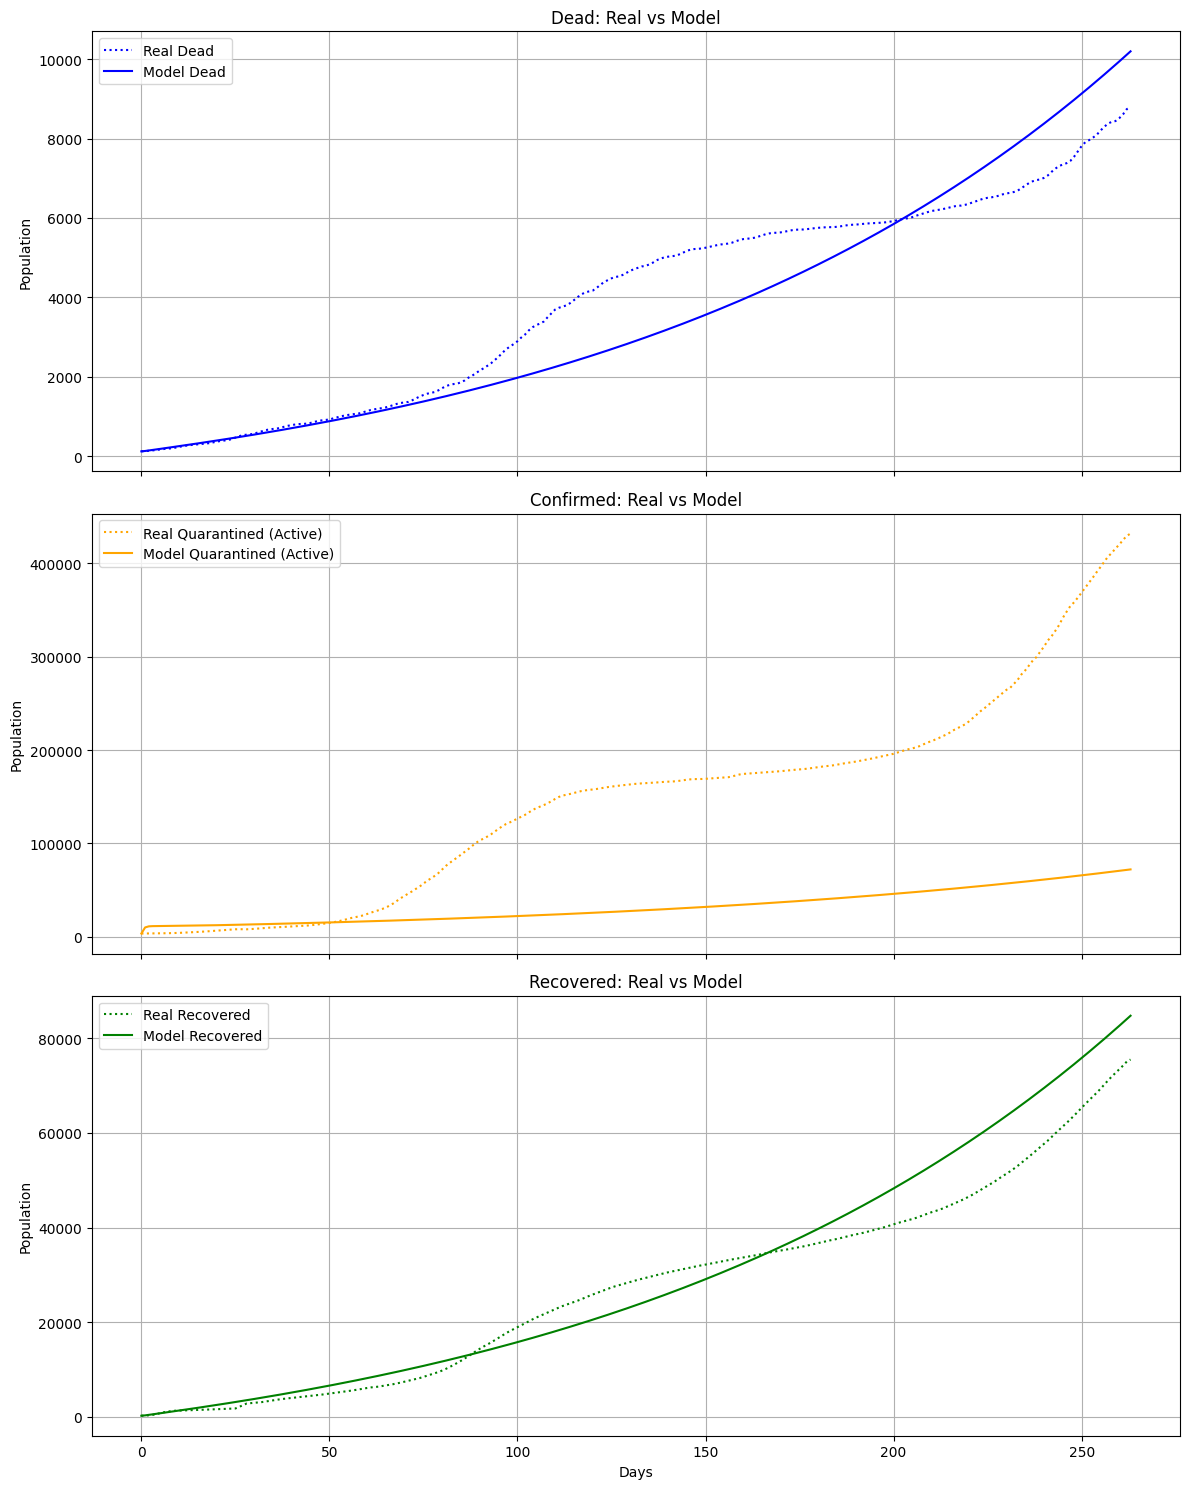

264
`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 3.6031e+04, final cost 3.2327e+00, first-order optimality 2.45e-02.
E0: 1000 I0: 1000 Final cost: 3.2327195449565527
`xtol` termination condition is satisfied.
Function evaluations 36, initial cost 3.6204e+04, final cost 3.1646e+00, first-order optimality 3.12e-01.
E0: 1000 I0: 1500 Final cost: 3.164624281705552
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 3.6351e+04, final cost 3.1400e+00, first-order optimality 1.73e-01.
E0: 1000 I0: 2000 Final cost: 3.1400417715236064
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 3.6479e+04, final cost 3.1192e+00, first-order optimality 3.05e-02.
E0: 1000 I0: 2500 Final cost: 3.1192349487434132
`ftol` termination condition is satisfied.
Function evaluations 36, initial cost 3.6592e+04, final cost 3.1005e+00, first-order optimality 2.21e-01.
E0: 1000 I0: 3000 Final cost: 3.1005478486755362
`ftol` 

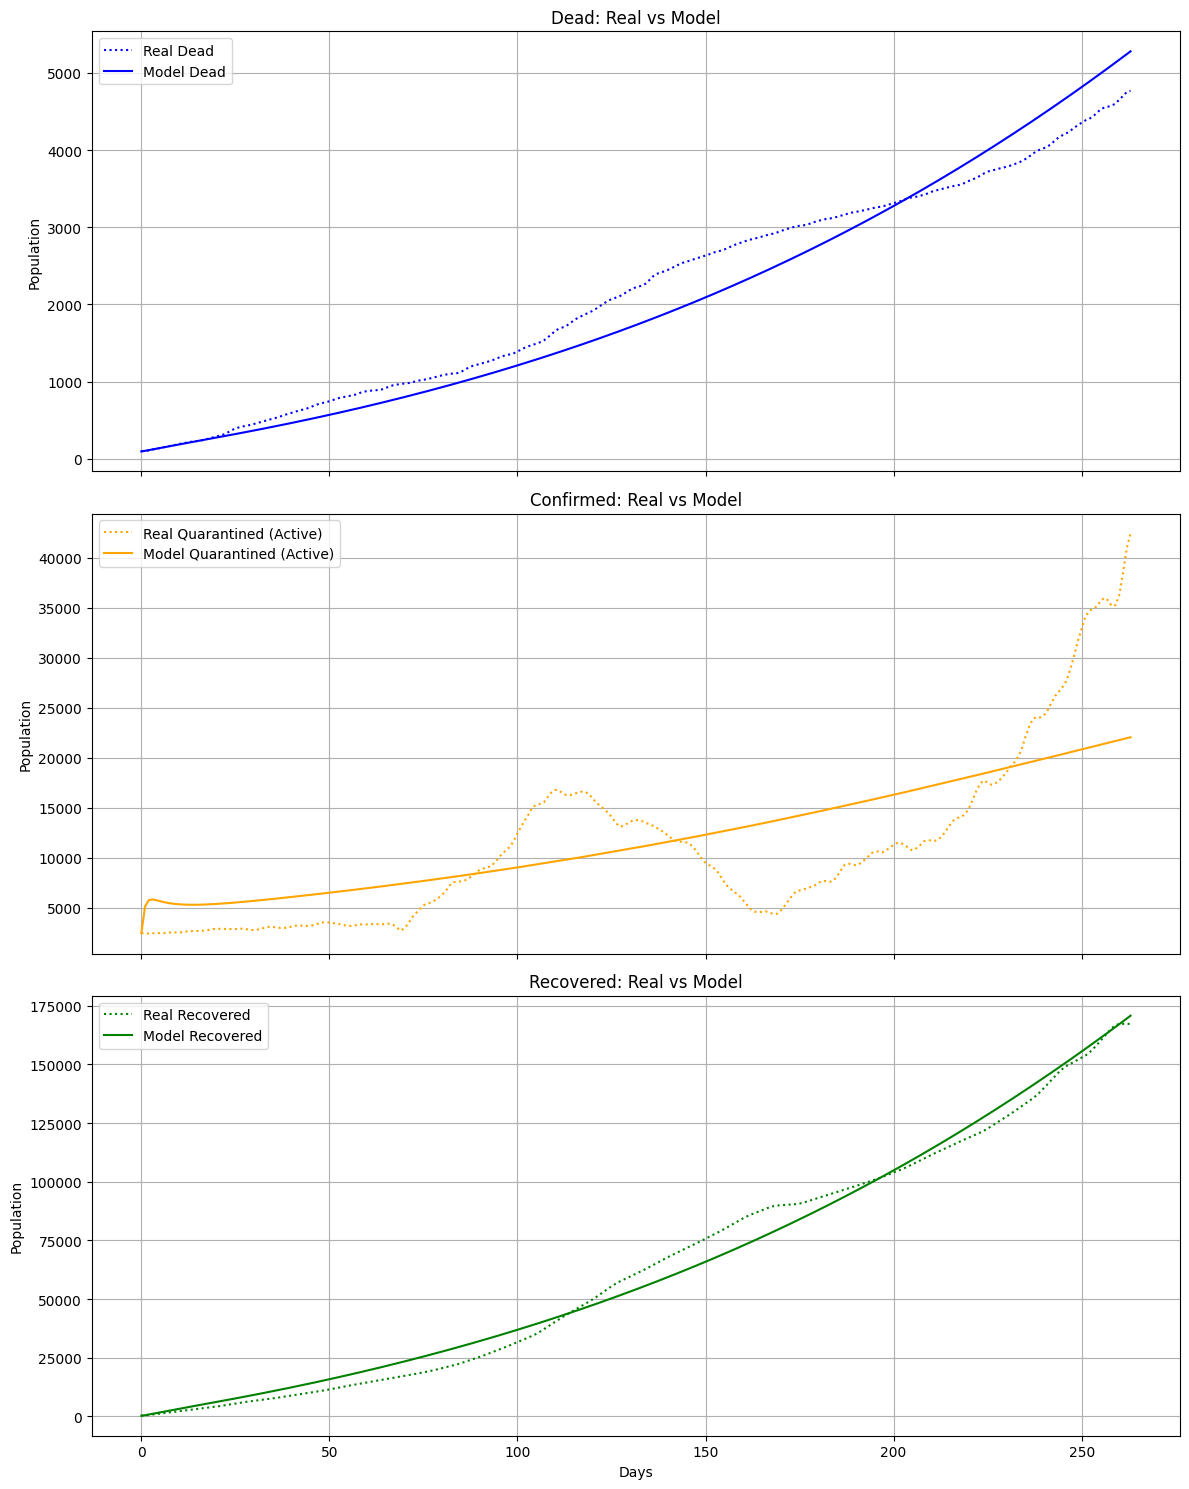

264
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 1.0486e+05, final cost 2.3960e+00, first-order optimality 5.73e-04.
E0: 1000 I0: 1000 Final cost: 2.3960476476819066
`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 1.0557e+05, final cost 2.4704e+00, first-order optimality 2.51e-03.
E0: 1000 I0: 1500 Final cost: 2.470362917041724
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 47, initial cost 1.0614e+05, final cost 2.5794e+00, first-order optimality 1.87e-03.
E0: 1000 I0: 2000 Final cost: 2.5793573915724126
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.0663e+05, final cost 2.7588e+00, first-order optimality 2.75e-03.
E0: 1000 I0: 2500 Final cost: 2.75884562315006
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 1.0705e+05, final cost 3.1145e+00, first-order optimality 1.06e-02.
E0: 1000 I0: 3000 Final cost: 3.11454243

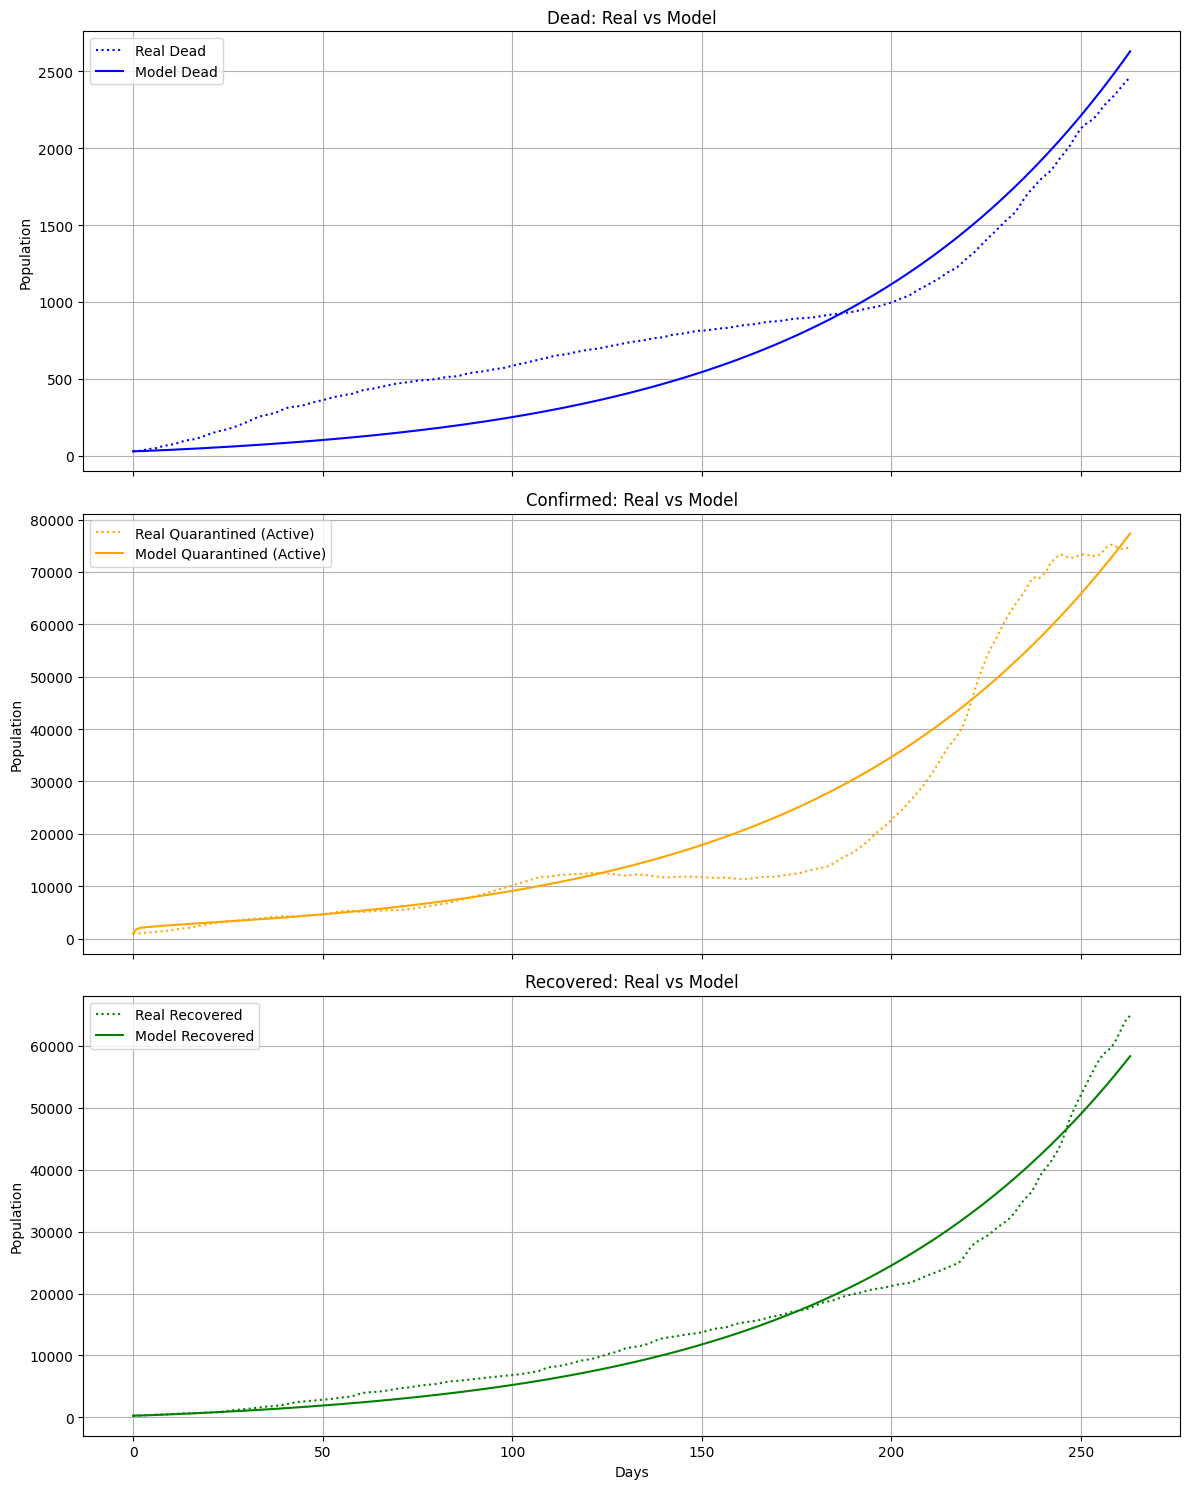

264
`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 5.2328e+04, final cost 6.8778e+00, first-order optimality 7.56e-04.
E0: 1000 I0: 1000 Final cost: 6.877775512701284
`ftol` termination condition is satisfied.
Function evaluations 36, initial cost 5.2476e+04, final cost 6.6388e+00, first-order optimality 2.66e-02.
E0: 1000 I0: 1500 Final cost: 6.638792342869422
`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 5.2609e+04, final cost 6.4156e+00, first-order optimality 2.17e-03.
E0: 1000 I0: 2000 Final cost: 6.4156141832818
`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 5.2732e+04, final cost 6.2067e+00, first-order optimality 5.07e-02.
E0: 1000 I0: 2500 Final cost: 6.206743462817941
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 5.2845e+04, final cost 6.0107e+00, first-order optimality 2.40e-03.
E0: 1000 I0: 3000 Final cost: 6.010745597692758
`ftol` termin

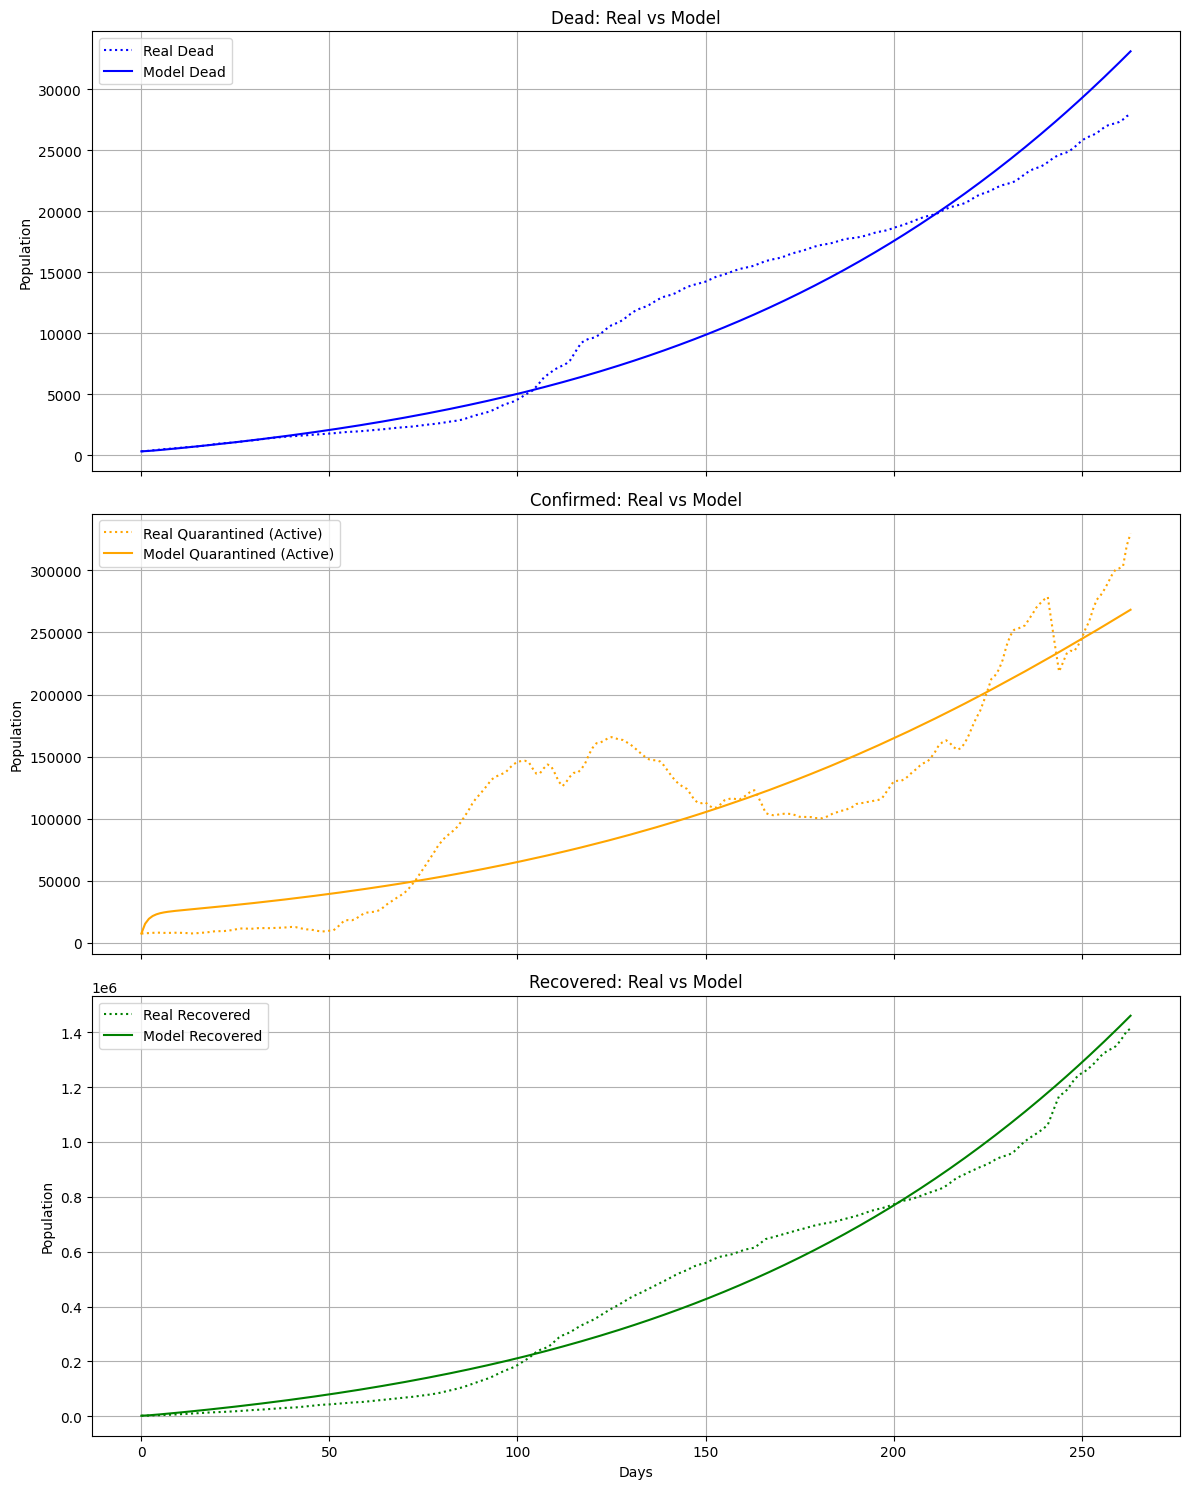

264
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 7.2706e+06, final cost 2.0968e+01, first-order optimality 3.15e-02.
E0: 1000 I0: 1000 Final cost: 20.96829911400191
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 7.2988e+06, final cost 2.0880e+01, first-order optimality 1.01e-01.
E0: 1000 I0: 1500 Final cost: 20.87957798936018
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 7.3237e+06, final cost 2.0828e+01, first-order optimality 1.41e-03.
E0: 1000 I0: 2000 Final cost: 20.827790165410747
`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 7.3460e+06, final cost 2.0808e+01, first-order optimality 1.71e+00.
E0: 1000 I0: 2500 Final cost: 20.808381605428195
`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 7.3662e+06, final cost 2.0808e+01, first-order optimality 8.12e-02.
E0: 1000 I0: 3000 Final cost: 20.808402488152122
`ftol` t

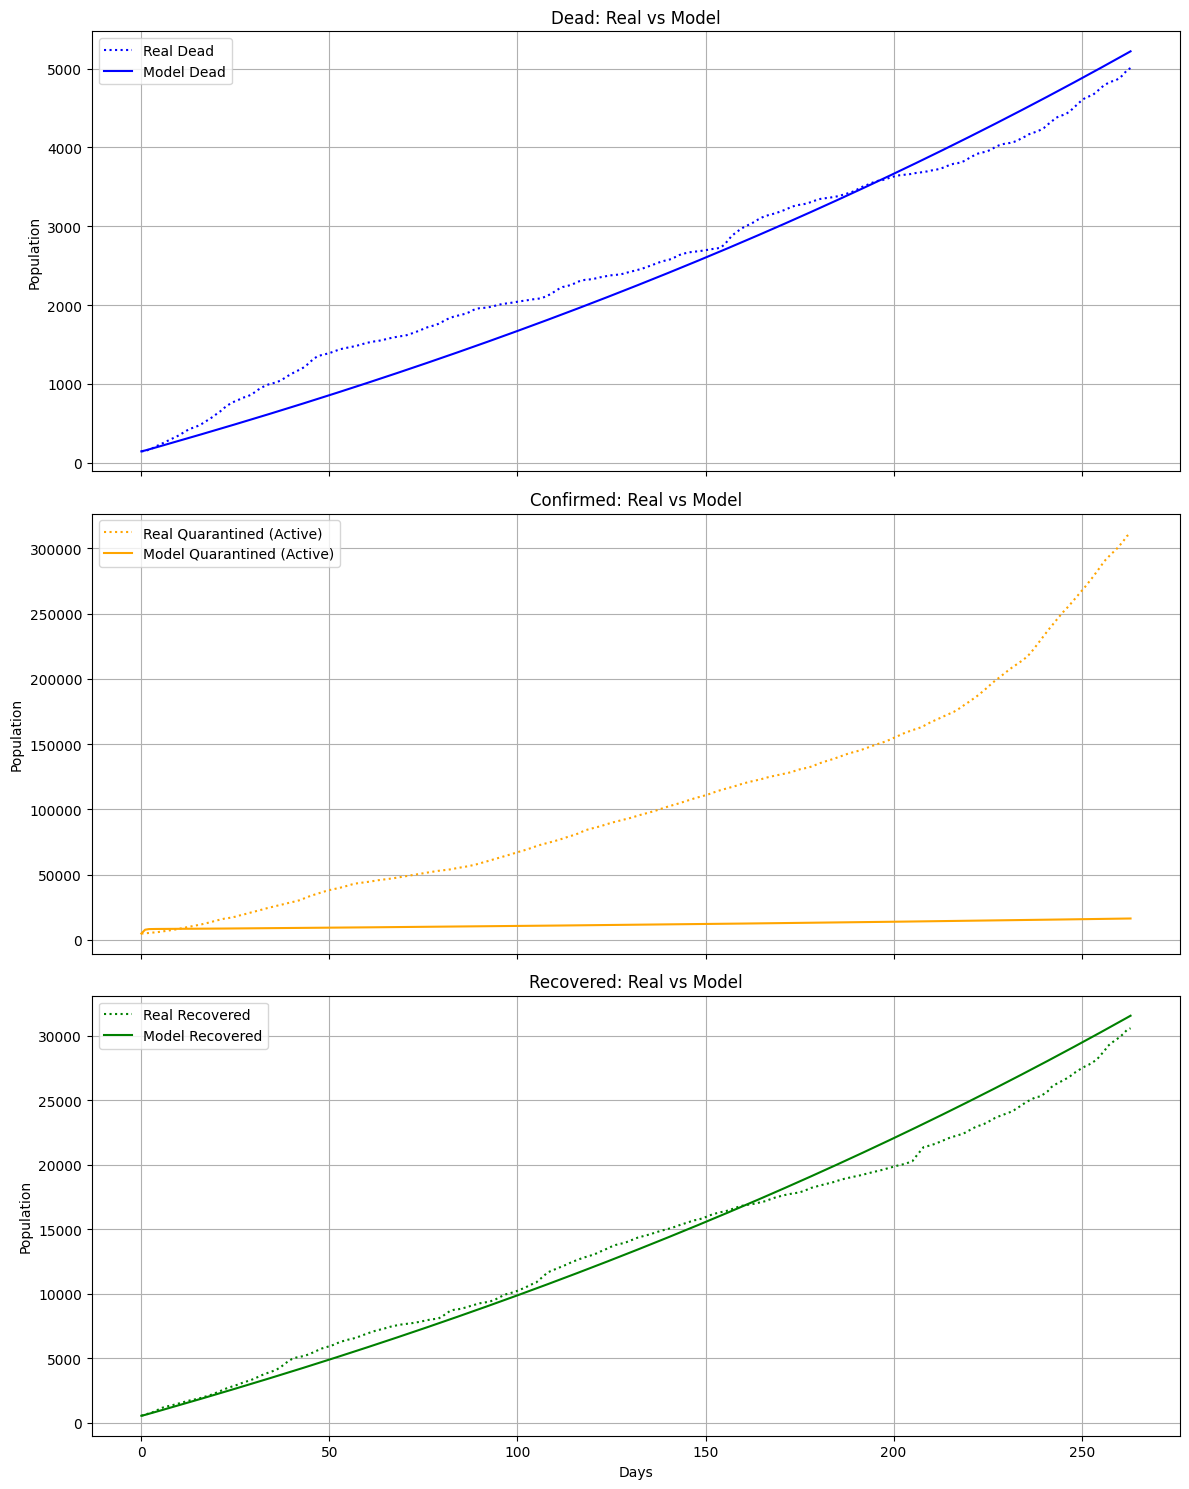

         State     alpha      beta     delta    Lambda     Kappa    E0    I0
0      arizona  0.102693  0.039378  1.722576  0.010000  0.001191  1000  8000
1  mississippi  0.100000  0.124073  1.253012  0.054702  0.001663  1000  4000
2   new mexico  0.100000  0.053994  1.831245  0.010056  0.000450  1000  1000
3        texas  0.500000  0.117282  1.222398  0.051253  0.001152  9500  9500
4     virginia  0.100023  0.029025  1.867714  0.010000  0.001637  1000  3500


In [13]:
import pathlib
State_name = ['arizona', 'mississippi', 'new mexico', 'texas', 'virginia']
path = pathlib.Path().resolve()  #path = "D:\MyDownload\Code\OD-COVID\datasets"
para_summary = []
for i in range(len(State_name)):
    name = State_name[i]
    df = pd.read_csv(os.path.join(path, name + '_cases_0412_1231.csv'))
    print(len(df))
    #initial_conditions = [(9500,9500),(1000,9500),(1000,1000),(9500,9500),(1000, 1000)]  # Example initial conditions for E0 and I0
    #parameters, E0, I0 = fit_function(df, initial_conditions[i])
    parameters, E0, I0 = fit_function(df)
    plot_comparea(df, parameters, E0, I0)
    # 记录参数结果
    para_summary.append((name, *parameters, E0, I0))

# 生成DataFrame
para_df = pd.DataFrame(para_summary, columns=['State', 'alpha', 'beta', 'delta', 'Lambda', 'Kappa', 'E0', 'I0'])
print(para_df)

In [ ]:
para_df.rename(columns={'Lambda': 'lambda', 'Kappa': 'kappa'}, inplace=True)
#para_df.to_csv('D:\MyDownload\Code\OD-COVID\datasets\seird_parameters_v1.csv', index=False)
para_df.to_csv(os.path.join(path, 'seird_parameters_step1.csv'), index=False)